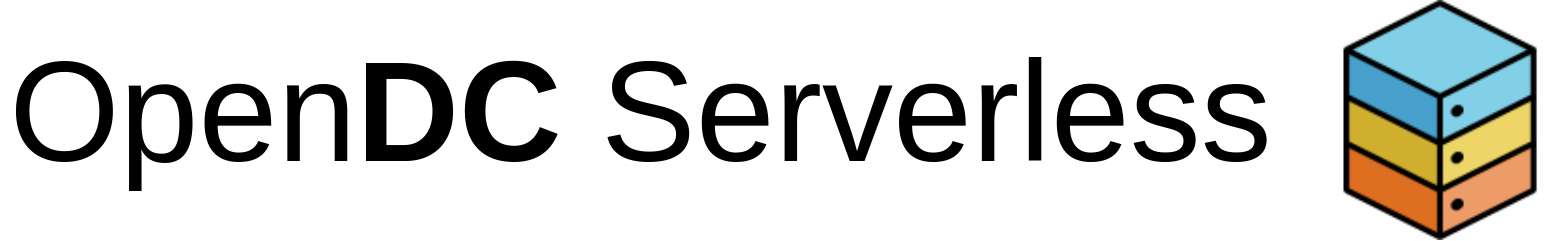
# Serverless in the Wild Reproduced experiment results analysis
This notebook contains a full analysis of the results of the Hybrid Histogram Experiment from the OpenDC Serverless paper.

This work accompanies the OpenDC Serverless bachelors thesis paper by Soufiane Jounaid within @Large Research

Vrije Universiteit Amsterdam 2020.

In [1]:
import sys
import warnings
import string
import re
import math
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.legend import Legend
from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
warnings.filterwarnings('ignore')

## Input handling

In [6]:
path_lookup = "resources/azure/function-indices.csv"

app_results = pd.read_csv(path_lookup, index_col=False) 

### Single iteration (For computing Function specific graphs)

In [5]:
iteration = "iteration1"
path= "resources/azure"

path_baseline = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet"

path_no_unloading = f"{path}/{iteration}/randomAlloc-randomRouting-no-terminationResourceManagement-0msLimit-18VM's.parquet"

path_fixed_5min = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-300000msTimeout-18VM's.parquet"
path_fixed_20min = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1200000msTimeout-18VM's.parquet"
path_fixed_30min = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1800000msTimeout-18VM's.parquet"
path_fixed_45min = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-2700000msTimeout-18VM's.parquet"
path_fixed_1hour = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-3600000msTimeout-18VM's.parquet"
path_fixed_1hour_30min = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-5400000msTimeout-18VM's.parquet"
path_fixed_2hour = f"{path}/{iteration}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-7200000msTimeout-18VM's.parquet"

path_hybrid_1hour = f"{path}/{iteration}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-3600000msLimit-18VM's.parquet"
path_hybrid_2hour = f"{path}/{iteration}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-7200000msLimit-18VM's.parquet"
path_hybrid_3hour = f"{path}/{iteration}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-10800000msLimit-18VM's.parquet"
path_hybrid_4hour = f"{path}/{iteration}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-14400000msLimit-18VM's.parquet"

results = {'baseline' : pd.read_parquet(path_baseline, engine = 'pyarrow'),
           'no_unloading' : pd.read_parquet(path_no_unloading, engine = 'pyarrow'),
           'fixed_5min' : pd.read_parquet(path_fixed_5min, engine = 'pyarrow'),
           'fixed_20min' : pd.read_parquet(path_fixed_20min, engine = 'pyarrow'),
           'fixed_30min' : pd.read_parquet(path_fixed_30min, engine = 'pyarrow'),
           'fixed_45min' : pd.read_parquet(path_fixed_45min, engine = 'pyarrow'),
           'fixed_60min' : pd.read_parquet(path_fixed_1hour, engine = 'pyarrow'),
           'fixed_90min' : pd.read_parquet(path_fixed_1hour_30min, engine = 'pyarrow'),
           'fixed_120min' : pd.read_parquet(path_fixed_2hour, engine = 'pyarrow'),
           'hybrid_1hour' : pd.read_parquet(path_hybrid_1hour, engine = 'pyarrow'),
           'hybrid_2hour' : pd.read_parquet(path_hybrid_2hour, engine = 'pyarrow'),
           'hybrid_3hour' : pd.read_parquet(path_hybrid_3hour, engine = 'pyarrow'),
           'hybrid_4hour' : pd.read_parquet(path_hybrid_4hour, engine = 'pyarrow'),} 

In [6]:
for key in results.keys():
    results.get(key)['Time'] = results.get(key)['Time'] / 86400000
    results.get(key)['Policy'] = key
    results.get(key)['Function'] = results.get(key)['Function'].astype(int)
    results.get(key)['NormWastedMemoryTime'] = results.get(key)['WastedMemoryTime'] * 100 / results.get('baseline')['WastedMemoryTime']

### 3 Iterations (for computing app specific graphs with confidence intervals only)

In [3]:
time = "iteration1"
path= "resources/azure"

path_baseline = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet"

path_no_unloading = f"{path}/{time}/randomAlloc-randomRouting-no-terminationResourceManagement-0msLimit-18VM's.parquet"

path_fixed_5min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-300000msTimeout-18VM's.parquet"
path_fixed_20min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1200000msTimeout-18VM's.parquet"
path_fixed_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1800000msTimeout-18VM's.parquet"
path_fixed_45min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-2700000msTimeout-18VM's.parquet"
path_fixed_1hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-3600000msTimeout-18VM's.parquet"
path_fixed_1hour_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-5400000msTimeout-18VM's.parquet"
path_fixed_2hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-7200000msTimeout-18VM's.parquet"

path_hybrid_1hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-3600000msLimit-18VM's.parquet"
path_hybrid_2hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-7200000msLimit-18VM's.parquet"
path_hybrid_3hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-10800000msLimit-18VM's.parquet"
path_hybrid_4hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-14400000msLimit-18VM's.parquet"

results1 = {'baseline' : pd.read_parquet(path_baseline, engine = 'pyarrow'),
            'no_unloading' : pd.read_parquet(path_no_unloading, engine = 'pyarrow'),
            'fixed_5min' : pd.read_parquet(path_fixed_5min, engine = 'pyarrow'),
            'fixed_20min' : pd.read_parquet(path_fixed_20min, engine = 'pyarrow'),
            'fixed_30min' : pd.read_parquet(path_fixed_30min, engine = 'pyarrow'),
            'fixed_45min' : pd.read_parquet(path_fixed_45min, engine = 'pyarrow'),
            'fixed_60min' : pd.read_parquet(path_fixed_1hour, engine = 'pyarrow'),
            'fixed_90min' : pd.read_parquet(path_fixed_1hour_30min, engine = 'pyarrow'),
            'fixed_120min' : pd.read_parquet(path_fixed_2hour, engine = 'pyarrow'),
            'hybrid_1hour' : pd.read_parquet(path_hybrid_1hour, engine = 'pyarrow'),
            'hybrid_2hour' : pd.read_parquet(path_hybrid_2hour, engine = 'pyarrow'),
            'hybrid_3hour' : pd.read_parquet(path_hybrid_3hour, engine = 'pyarrow'),
            'hybrid_4hour' : pd.read_parquet(path_hybrid_4hour, engine = 'pyarrow'),} 

for key in results1.keys():
    results1.get(key)['Time'] = results1.get(key)['Time'] / 86400000
    results1.get(key)['Policy'] = key
    results1.get(key)['Function'] = results1.get(key)['Function'].astype(int)
    results1.get(key)['NormWastedMemoryTime'] = results1.get(key)['WastedMemoryTime'] * 100 / results1.get('baseline')['WastedMemoryTime']

results1.update({'baseline' : results1.get('baseline')[results1.get('baseline')['Time'] == 7.0],
                 'no_unloading' : results1.get('no_unloading')[results1.get('no_unloading')['Time'] == 7.0],
                 'fixed_5min' : results1.get('fixed_5min')[results1.get('fixed_5min')['Time'] == 7.0],
                 'fixed_20min' : results1.get('fixed_20min')[results1.get('fixed_20min')['Time'] == 7.0],
                 'fixed_30min' : results1.get('fixed_30min')[results1.get('fixed_30min')['Time'] == 7.0],
                 'fixed_45min' : results1.get('fixed_45min')[results1.get('fixed_45min')['Time'] == 7.0],
                 'fixed_60min' : results1.get('fixed_60min')[results1.get('fixed_60min')['Time'] == 7.0],
                 'fixed_90min' : results1.get('fixed_90min')[results1.get('fixed_90min')['Time'] == 7.0],
                 'fixed_120min' : results1.get('fixed_120min')[results1.get('fixed_120min')['Time'] == 7.0],
                 'hybrid_1hour' : results1.get('hybrid_1hour')[results1.get('hybrid_1hour')['Time'] == 7.0],
                 'hybrid_2hour' : results1.get('hybrid_2hour')[results1.get('hybrid_2hour')['Time'] == 7.0],
                 'hybrid_3hour' : results1.get('hybrid_3hour')[results1.get('hybrid_3hour')['Time'] == 7.0],
                 'hybrid_4hour' : results1.get('hybrid_4hour')[results1.get('hybrid_4hour')['Time'] == 7.0]})
    

In [4]:
time = "iteration2"
path= "resources/azure"

path_baseline = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet"

path_no_unloading = f"{path}/{time}/randomAlloc-randomRouting-no-terminationResourceManagement-0msLimit-18VM's.parquet"

path_fixed_5min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-300000msTimeout-18VM's.parquet"
path_fixed_20min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1200000msTimeout-18VM's.parquet"
path_fixed_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1800000msTimeout-18VM's.parquet"
path_fixed_45min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-2700000msTimeout-18VM's.parquet"
path_fixed_1hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-3600000msTimeout-18VM's.parquet"
path_fixed_1hour_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-5400000msTimeout-18VM's.parquet"
path_fixed_2hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-7200000msTimeout-18VM's.parquet"

path_hybrid_1hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-3600000msLimit-18VM's.parquet"
path_hybrid_2hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-7200000msLimit-18VM's.parquet"
path_hybrid_3hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-10800000msLimit-18VM's.parquet"
path_hybrid_4hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-14400000msLimit-18VM's.parquet"

path_lookup = "/home/soufianej/Documents/Bachelors_project/serverless-simulator/serverless/indices.csv"

results2 = {'baseline' : pd.read_parquet(path_baseline, engine = 'pyarrow'),
            'no_unloading' : pd.read_parquet(path_no_unloading, engine = 'pyarrow'),
            'fixed_5min' : pd.read_parquet(path_fixed_5min, engine = 'pyarrow'),
            'fixed_20min' : pd.read_parquet(path_fixed_20min, engine = 'pyarrow'),
            'fixed_30min' : pd.read_parquet(path_fixed_30min, engine = 'pyarrow'),
            'fixed_45min' : pd.read_parquet(path_fixed_45min, engine = 'pyarrow'),
            'fixed_60min' : pd.read_parquet(path_fixed_1hour, engine = 'pyarrow'),
            'fixed_90min' : pd.read_parquet(path_fixed_1hour_30min, engine = 'pyarrow'),
            'fixed_120min' : pd.read_parquet(path_fixed_2hour, engine = 'pyarrow'),
            'hybrid_1hour' : pd.read_parquet(path_hybrid_1hour, engine = 'pyarrow'),
            'hybrid_2hour' : pd.read_parquet(path_hybrid_2hour, engine = 'pyarrow'),
            'hybrid_3hour' : pd.read_parquet(path_hybrid_3hour, engine = 'pyarrow'),
            'hybrid_4hour' : pd.read_parquet(path_hybrid_4hour, engine = 'pyarrow'),} 
    
for key in results2.keys():
    results2.get(key)['Time'] = results2.get(key)['Time'] / 86400000
    results2.get(key)['Policy'] = key
    results2.get(key)['Function'] = results2.get(key)['Function'].astype(int)
    results2.get(key)['NormWastedMemoryTime'] = results2.get(key)['WastedMemoryTime'] * 100 / results2.get('baseline')['WastedMemoryTime']

results2.update({'baseline' : results2.get('baseline')[results2.get('baseline')['Time'] == 7.0],
                 'no_unloading' : results1.get('no_unloading')[results1.get('no_unloading')['Time'] == 7.0],
                 'fixed_5min' : results2.get('fixed_5min')[results2.get('fixed_5min')['Time'] == 7.0],
                 'fixed_20min' : results2.get('fixed_20min')[results2.get('fixed_20min')['Time'] == 7.0],
                 'fixed_30min' : results2.get('fixed_30min')[results2.get('fixed_30min')['Time'] == 7.0],
                 'fixed_45min' : results2.get('fixed_45min')[results2.get('fixed_45min')['Time'] == 7.0],
                 'fixed_60min' : results2.get('fixed_60min')[results2.get('fixed_60min')['Time'] == 7.0],
                 'fixed_90min' : results2.get('fixed_90min')[results2.get('fixed_90min')['Time'] == 7.0],
                 'fixed_120min' : results2.get('fixed_120min')[results2.get('fixed_120min')['Time'] == 7.0],
                 'hybrid_1hour' : results2.get('hybrid_1hour')[results2.get('hybrid_1hour')['Time'] == 7.0],
                 'hybrid_2hour' : results2.get('hybrid_2hour')[results2.get('hybrid_2hour')['Time'] == 7.0],
                 'hybrid_3hour' : results2.get('hybrid_3hour')[results2.get('hybrid_3hour')['Time'] == 7.0],
                 'hybrid_4hour' : results2.get('hybrid_4hour')[results2.get('hybrid_4hour')['Time'] == 7.0]})

In [5]:
time = "iteration3"
path= "resources/azure"

path_baseline = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-600000msTimeout-18VM's.parquet"

path_no_unloading = f"{path}/{time}/randomAlloc-randomRouting-no-terminationResourceManagement-0msLimit-18VM's.parquet"

path_fixed_5min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-300000msTimeout-18VM's.parquet"
path_fixed_20min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1200000msTimeout-18VM's.parquet"
path_fixed_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-1800000msTimeout-18VM's.parquet"
path_fixed_45min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-2700000msTimeout-18VM's.parquet"
path_fixed_1hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-3600000msTimeout-18VM's.parquet"
path_fixed_1hour_30min = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-5400000msTimeout-18VM's.parquet"
path_fixed_2hour = f"{path}/{time}/randomAlloc-randomRouting-fixed-keep-aliveResourceManagement-7200000msTimeout-18VM's.parquet"

path_hybrid_1hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-3600000msLimit-18VM's.parquet"
path_hybrid_2hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-7200000msLimit-18VM's.parquet"
path_hybrid_3hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-10800000msLimit-18VM's.parquet"
path_hybrid_4hour = f"{path}/{time}/randomAlloc-randomRouting-hybrid-histogramResourceManagement-14400000msLimit-18VM's.parquet"

path_lookup = "/home/soufianej/Documents/Bachelors_project/serverless-simulator/serverless/indices.csv"

results3 = {'baseline' : pd.read_parquet(path_baseline, engine = 'pyarrow'),
            'no_unloading' : pd.read_parquet(path_no_unloading, engine = 'pyarrow'),
            'fixed_5min' : pd.read_parquet(path_fixed_5min, engine = 'pyarrow'),
            'fixed_20min' : pd.read_parquet(path_fixed_20min, engine = 'pyarrow'),
            'fixed_30min' : pd.read_parquet(path_fixed_30min, engine = 'pyarrow'),
            'fixed_45min' : pd.read_parquet(path_fixed_45min, engine = 'pyarrow'),
            'fixed_60min' : pd.read_parquet(path_fixed_1hour, engine = 'pyarrow'),
            'fixed_90min' : pd.read_parquet(path_fixed_1hour_30min, engine = 'pyarrow'),
            'fixed_120min' : pd.read_parquet(path_fixed_2hour, engine = 'pyarrow'),
            'hybrid_1hour' : pd.read_parquet(path_hybrid_1hour, engine = 'pyarrow'),
            'hybrid_2hour' : pd.read_parquet(path_hybrid_2hour, engine = 'pyarrow'),
            'hybrid_3hour' : pd.read_parquet(path_hybrid_3hour, engine = 'pyarrow'),
            'hybrid_4hour' : pd.read_parquet(path_hybrid_4hour, engine = 'pyarrow'),} 

for key in results3.keys():
    results3.get(key)['Time'] = results3.get(key)['Time'] / 86400000
    results3.get(key)['Policy'] = key
    results3.get(key)['Function'] = results3.get(key)['Function'].astype(int)
    results3.get(key)['NormWastedMemoryTime'] = results3.get(key)['WastedMemoryTime'] * 100 / results3.get('baseline')['WastedMemoryTime']

results3.update({'baseline' : results3.get('baseline')[results3.get('baseline')['Time'] == 7.0],
                 'no_unloading' : results1.get('no_unloading')[results1.get('no_unloading')['Time'] == 7.0],
                 'fixed_5min' : results3.get('fixed_5min')[results3.get('fixed_5min')['Time'] == 7.0],
                 'fixed_20min' : results3.get('fixed_20min')[results3.get('fixed_20min')['Time'] == 7.0],
                 'fixed_30min' : results3.get('fixed_30min')[results3.get('fixed_30min')['Time'] == 7.0],
                 'fixed_45min' : results3.get('fixed_45min')[results3.get('fixed_45min')['Time'] == 7.0],
                 'fixed_60min' : results3.get('fixed_60min')[results3.get('fixed_60min')['Time'] == 7.0],
                 'fixed_90min' : results3.get('fixed_90min')[results3.get('fixed_90min')['Time'] == 7.0],
                 'fixed_120min' : results3.get('fixed_120min')[results3.get('fixed_120min')['Time'] == 7.0],
                 'hybrid_1hour' : results3.get('hybrid_1hour')[results3.get('hybrid_1hour')['Time'] == 7.0],
                 'hybrid_2hour' : results3.get('hybrid_2hour')[results3.get('hybrid_2hour')['Time'] == 7.0],
                 'hybrid_3hour' : results3.get('hybrid_3hour')[results3.get('hybrid_3hour')['Time'] == 7.0],
                 'hybrid_4hour' : results3.get('hybrid_4hour')[results3.get('hybrid_4hour')['Time'] == 7.0]})

## Trade off results pre processing (skip this if the tradeoff results are computed)

### Reconstructing applications 
grouping functions indices that belong to the same app

In [6]:
app_results.drop('Count', axis=1, inplace=True)
app_results.drop('popularity', axis=1, inplace=True)
apps = app_results.set_index('HashApp')['indices'].to_dict()

for key in apps.keys():
    old = apps.get(key)
    funcs = re.findall(r'\d+', old)
    funcs = [int(i) for i in funcs] 
    apps.update({key : funcs})

### Computing each app's NormWastedMemoryTime and Cold start percentage

Wasted memory time is normalized to the baseline (fixed 10 min keep alive policy)

In [7]:
app_results['No_UnloadingWastedMemoryTime'] = 0

app_results['Fixed_5minWastedMemoryTime'] = 0
app_results['BaselineWastedMemoryTime'] = 0
app_results['Fixed_20minWastedMemoryTime'] = 0
app_results['Fixed_30minWastedMemoryTime'] = 0
app_results['Fixed_45minWastedMemoryTime'] = 0
app_results['Fixed_60minWastedMemoryTime'] = 0
app_results['Fixed_90minWastedMemoryTime'] = 0
app_results['Fixed_120minWastedMemoryTime'] = 0

app_results['Hybrid_1hourWastedMemoryTime'] = 0
app_results['Hybrid_2hourWastedMemoryTime'] = 0
app_results['Hybrid_3hourWastedMemoryTime'] = 0
app_results['Hybrid_4hourWastedMemoryTime'] = 0

app_results['No_UnloadingNormWastedMemoryTime'] = 0

app_results['Fixed_5minNormWastedMemoryTime'] = 0
app_results['BaselineNormWastedMemoryTime'] = 0
app_results['Fixed_20minNormWastedMemoryTime'] = 0
app_results['Fixed_30minNormWastedMemoryTime'] = 0
app_results['Fixed_45minNormWastedMemoryTime'] = 0
app_results['Fixed_60minNormWastedMemoryTime'] = 0
app_results['Fixed_90minNormWastedMemoryTime'] = 0
app_results['Fixed_120minNormWastedMemoryTime'] = 0

app_results['Hybrid_1hourNormWastedMemoryTime'] = 0
app_results['Hybrid_2hourNormWastedMemoryTime'] = 0
app_results['Hybrid_3hourNormWastedMemoryTime'] = 0
app_results['Hybrid_4hourNormWastedMemoryTime'] = 0

app_results['No_UnloadingColdStartPct'] = 0

app_results['Fixed_5minColdStartPct'] = 0
app_results['BaselineColdStartPct'] = 0
app_results['Fixed_20minColdStartPct'] = 0
app_results['Fixed_30minColdStartPct'] = 0
app_results['Fixed_45minColdStartPct'] = 0
app_results['Fixed_60minColdStartPct'] = 0
app_results['Fixed_90minColdStartPct'] = 0
app_results['Fixed_120minColdStartPct'] = 0

app_results['Hybrid_1hourColdStartPct'] = 0
app_results['Hybrid_2hourColdStartPct'] = 0
app_results['Hybrid_3hourColdStartPct'] = 0
app_results['Hybrid_4hourColdStartPct'] = 0

In [8]:
def compute_and_normalize(app, indices, data, baseline, prefix, exclude, result_target):
    baseline_waste = 0
    memory_waste = 0
    invocations = 0
    coldstarts = 0
    
    for func in indices.get(app):
        if (func in exclude):
            continue
        
        baseline_waste += baseline.loc[(baseline['Time'] == 7.0) & (baseline['Function'] == func),'WastedMemoryTime'].values[0]
        memory_waste += data.loc[(data['Time'] == 7.0) & (data['Function'] == func),'WastedMemoryTime'].values[0]
        invocations += data.loc[(data['Time'] == 7.0) & (data['Function'] == func),'TotalInvocations'].values[0]
        coldstarts += data.loc[(data['Time'] == 7.0) & (data['Function'] == func),'TotalColdStarts'].values[0]

    result_target.loc[result_target['HashApp'] == app, f'{prefix}ColdStartPct'] = coldstarts * 100 / invocations  
    result_target.loc[result_target['HashApp'] == app, f'{prefix}WastedMemoryTime'] = memory_waste

    if baseline_waste == 0:
        result_target.loc[result_target['HashApp'] == app, f'{prefix}NormWastedMemoryTime'] = memory_waste
    else:
        result_target.loc[result_target['HashApp'] == app, f'{prefix}NormWastedMemoryTime'] = memory_waste * 100 / baseline_waste    

In [10]:
for app in apps.keys():
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('no_unloading'),
                          baseline=results.get('baseline'),
                          prefix="No_Unloading", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_5min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_5min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('baseline'),
                          baseline=results.get('baseline'),
                          prefix="Baseline", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_20min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_20min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_30min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_30min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_45min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_45min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_60min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_60min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_90min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_90min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('fixed_120min'),
                          baseline=results.get('baseline'),
                          prefix="Fixed_120min", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('hybrid_1hour'),
                          baseline=results.get('baseline'),
                          prefix="Hybrid_1hour", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('hybrid_2hour'),
                          baseline=results.get('baseline'),
                          prefix="Hybrid_2hour", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('hybrid_3hour'),
                          baseline=results.get('baseline'),
                          prefix="Hybrid_3hour", 
                          exclude=[78,157],
                          result_target=app_results)
    compute_and_normalize(app=app, 
                          indices=apps, 
                          data=results.get('hybrid_4hour'),
                          baseline=results.get('baseline'),
                          prefix="Hybrid_4hour", 
                          exclude=[78,157],
                          result_target=app_results)

# uncomment this and specify path to export processed results
# app_results.to_csv("", index=False)

## Function specific comparision graphs
Run the single iteration before proceeding with this part

In [6]:
sns.set()

Choose a function and two policies to compare

In [8]:
function_index = 150
left = "fixed_120min"
right = "hybrid_4hour"

In [9]:
tidy_data = pd.concat([results[left], results[right]]).reset_index(drop=True)

### Evolution of normalized sum wasted memory time

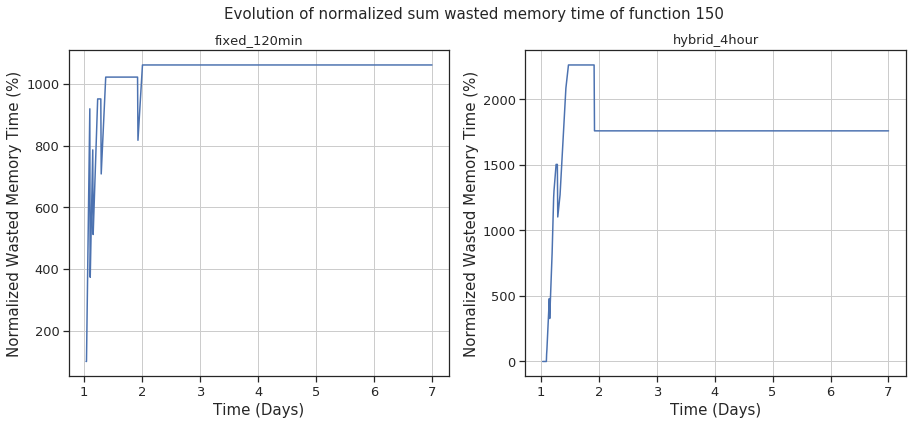

In [22]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):

    fig, ax =plt.subplots(1,2, figsize= (15,6))

    fig.suptitle(f'Evolution of normalized sum wasted memory time of function {function_index}', fontsize=15)

    ax[0].set_title(f"{left}", fontsize=13)
    ax[1].set_title(f"{right}", fontsize=13)

    sns.lineplot(x="Time", y="NormWastedMemoryTime", data= results.get(left)[results.get(left)["Function"] == function_index], ax=ax[0])
    sns.lineplot(x="Time", y="NormWastedMemoryTime", data= results.get(right)[results.get(right)["Function"] == function_index], ax=ax[1])

    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].tick_params(axis='both', which='minor', labelsize=13)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].tick_params(axis='both', which='minor', labelsize=13)
    
    ax[0].set_xlabel('Time (Days)', fontsize=15)
    ax[0].set_ylabel('Normalized Wasted Memory Time (%)', fontsize=15)
    ax[1].set_xlabel('Time (Days)', fontsize=15)
    ax[1].set_ylabel('Normalized Wasted Memory Time (%)', fontsize=15)

### Evolution of cold start percentage

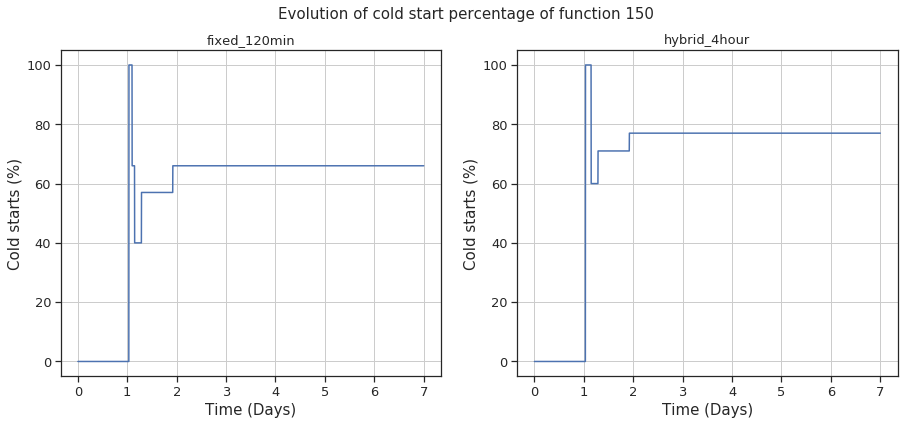

In [23]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(1,2, figsize= (15,6))

    fig.suptitle(f'Evolution of cold start percentage of function {function_index}', fontsize=15)

    ax[0].set_title(f"{left}", fontsize=13)
    ax[1].set_title(f"{right}", fontsize=13)

    sns.lineplot(x="Time", y="ColdStartsPct", data= results.get(left)[results.get(left)["Function"] == function_index ], ax=ax[0])
    sns.lineplot(x="Time", y="ColdStartsPct", data= results.get(right)[results.get(right)["Function"] == function_index], ax=ax[1])

    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].tick_params(axis='both', which='minor', labelsize=13)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].tick_params(axis='both', which='minor', labelsize=13)
    
    ax[0].set_xlabel('Time (Days)', fontsize=15)
    ax[0].set_ylabel('Cold starts (%)', fontsize=15)
    ax[1].set_xlabel('Time (Days)', fontsize=15)
    ax[1].set_ylabel('Cold starts (%)', fontsize=15)

### Multi line / Facet Grid Cold start and normalized wasted memory time evolution (Bonus)

#### Multi line cold start evolution 

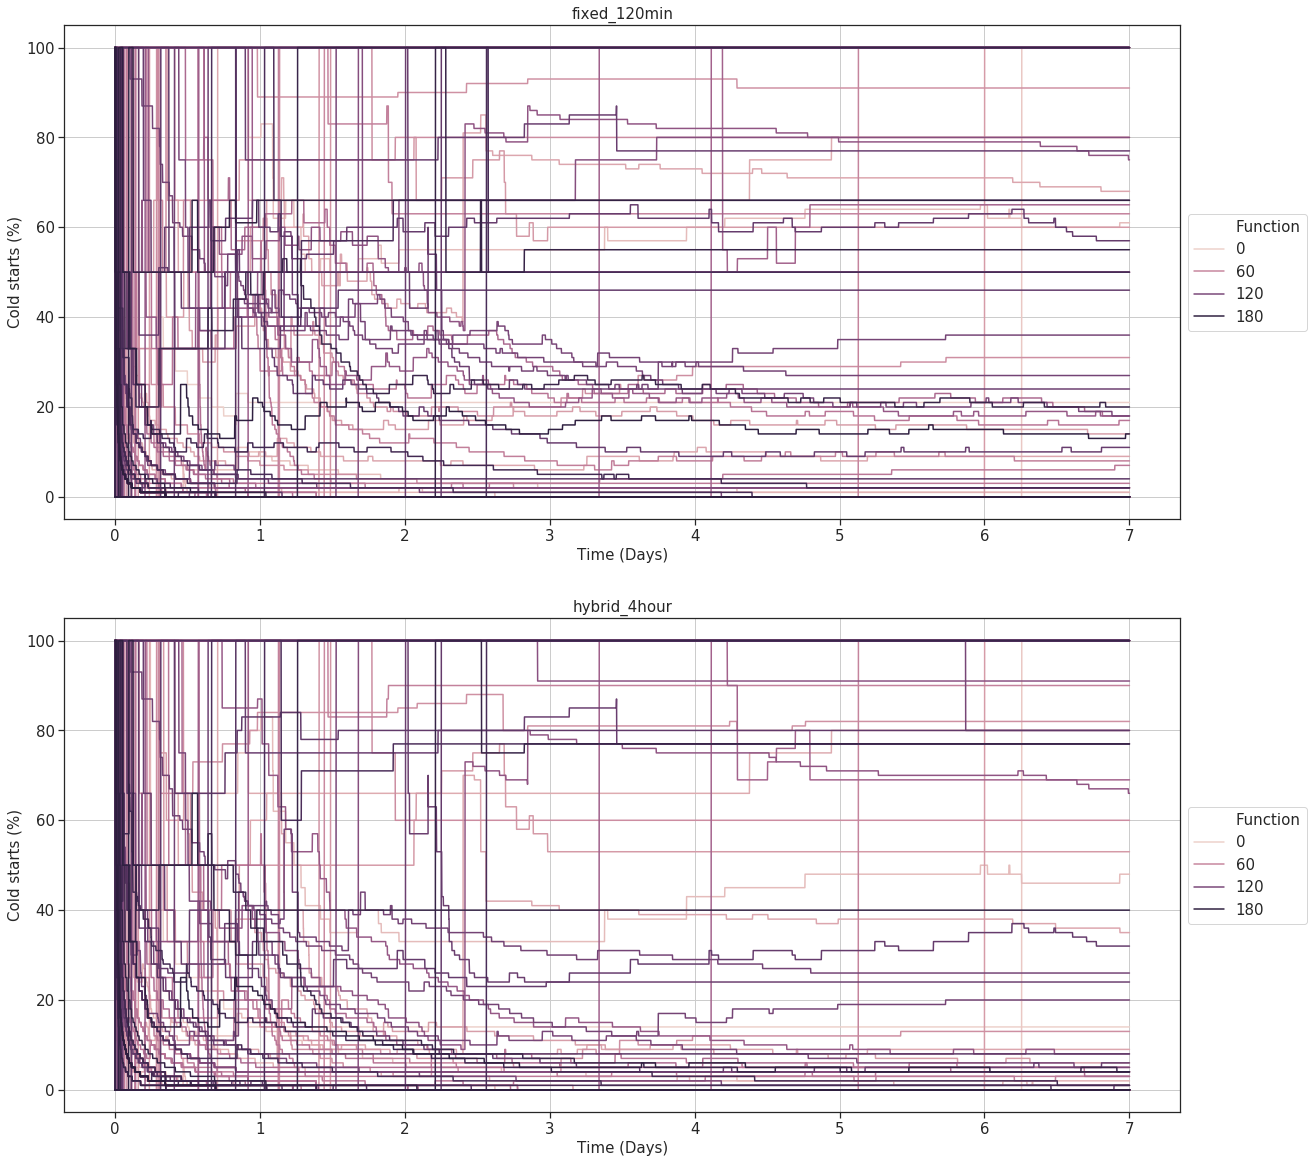

In [11]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2,1, figsize= (20,20))

    ax[0].set_title(f"{left}", fontsize=15)
    ax[1].set_title(f"{right}", fontsize=15)

    sns.lineplot(x="Time", y="ColdStartsPct", hue="Function", data= results.get(left), ax=ax[0])
    sns.lineplot(x="Time", y="ColdStartsPct", hue="Function", data= results.get(right), ax=ax[1])

    ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fontsize=15)
    ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fontsize=15)
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

    ax[0].set_xlabel('Time (Days)', fontsize=15)
    ax[0].set_ylabel('Cold starts (%)', fontsize=15)
    ax[1].set_xlabel('Time (Days)', fontsize=15)
    ax[1].set_ylabel('Cold starts (%)', fontsize=15)
    
    plt.savefig("bonuslinegraph.pdf", bbox_inches='tight')

#### Multi line Normalized Wasted Memory Time evolution

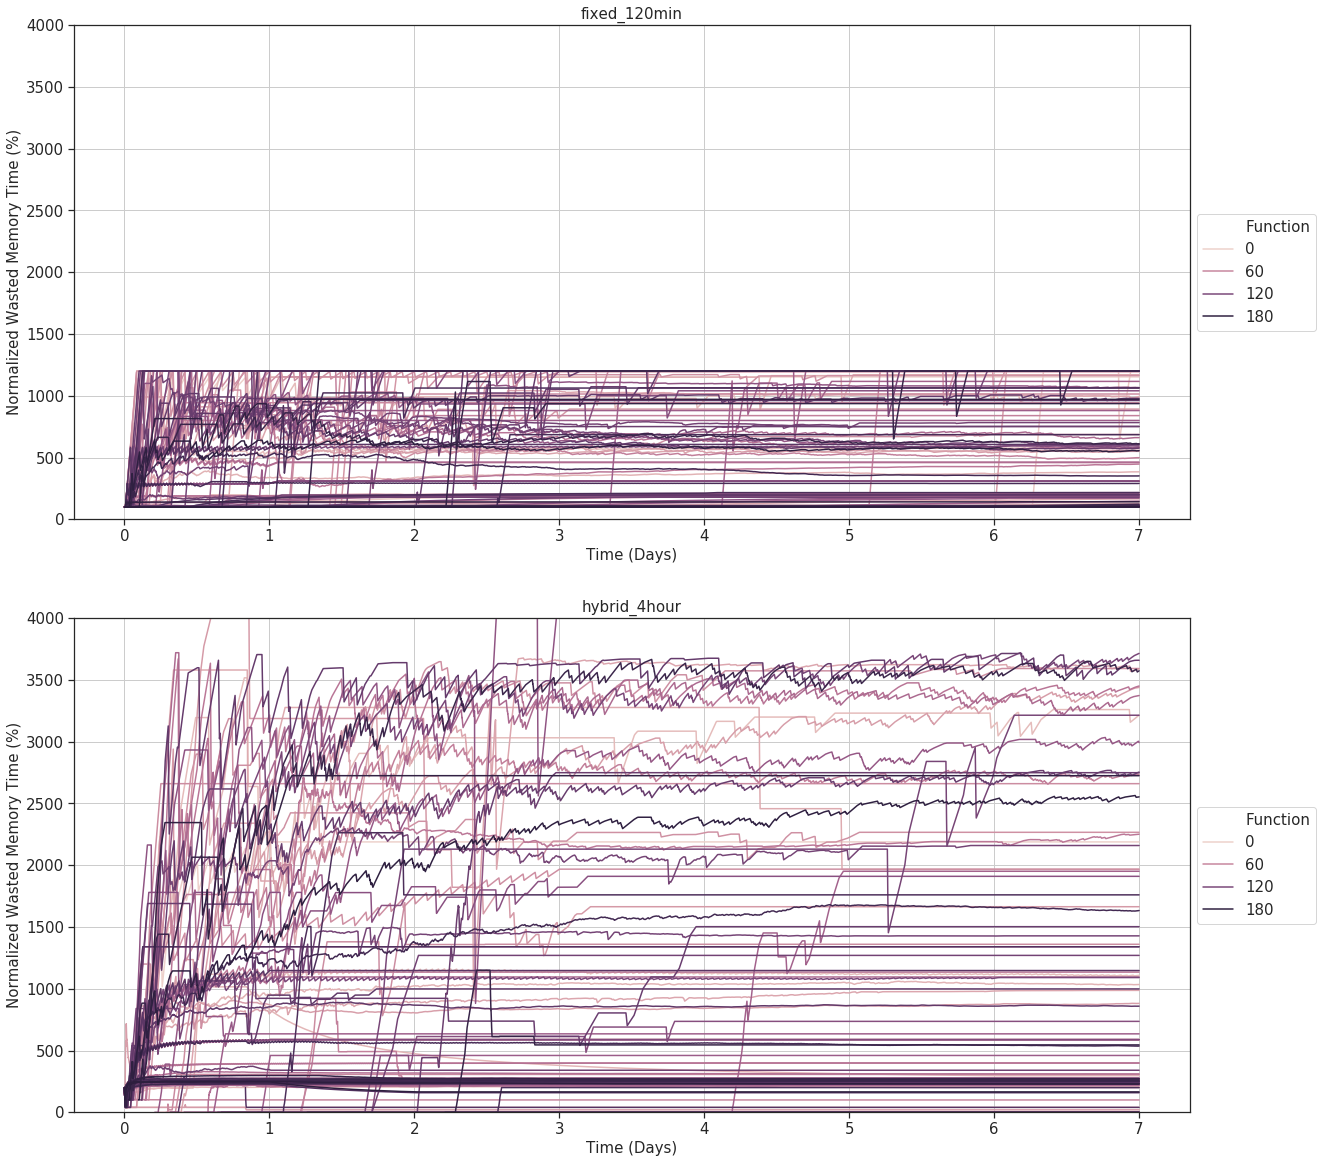

In [25]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2,1, figsize= (20,20))

    ax[0].set_title(f"{left}", fontsize=15)
    ax[1].set_title(f"{right}", fontsize=15)

    sns.lineplot(x="Time", y="NormWastedMemoryTime", hue="Function", data= results.get(left), ax=ax[0]).set(ylim=(0, 4000))
    sns.lineplot(x="Time", y="NormWastedMemoryTime", hue="Function", data= results.get(right), ax=ax[1]).set(ylim=(0, 4000))

    ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fontsize=15)
    ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1, fontsize=15)
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

    ax[0].set_xlabel('Time (Days)', fontsize=15)
    ax[0].set_ylabel('Normalized Wasted Memory Time (%)', fontsize=15)
    ax[1].set_xlabel('Time (Days)', fontsize=15)
    ax[1].set_ylabel('Normalized Wasted Memory Time (%)', fontsize=15)

#### Facet Grid Cold Start Percentage Evolution 

In [13]:
facet_palette={'fixed_5min': "#f88a9f",
               'baseline': "#f88a9f",
               'fixed_20min': "#f88a9f",
               'fixed_30min': "#f88a9f",
               'fixed_45min': "#f88a9f",
               'fixed_60min': "#f88a9f",
               'fixed_90min': "#f88a9f",
               'fixed_120min':"#f88a9f",
               'hybrid_1hour': "#82ccc6",
               'hybrid_2hour': "#82ccc6",
               'hybrid_3hour': "#82ccc6",
               'hybrid_4hour': "#82ccc6"}

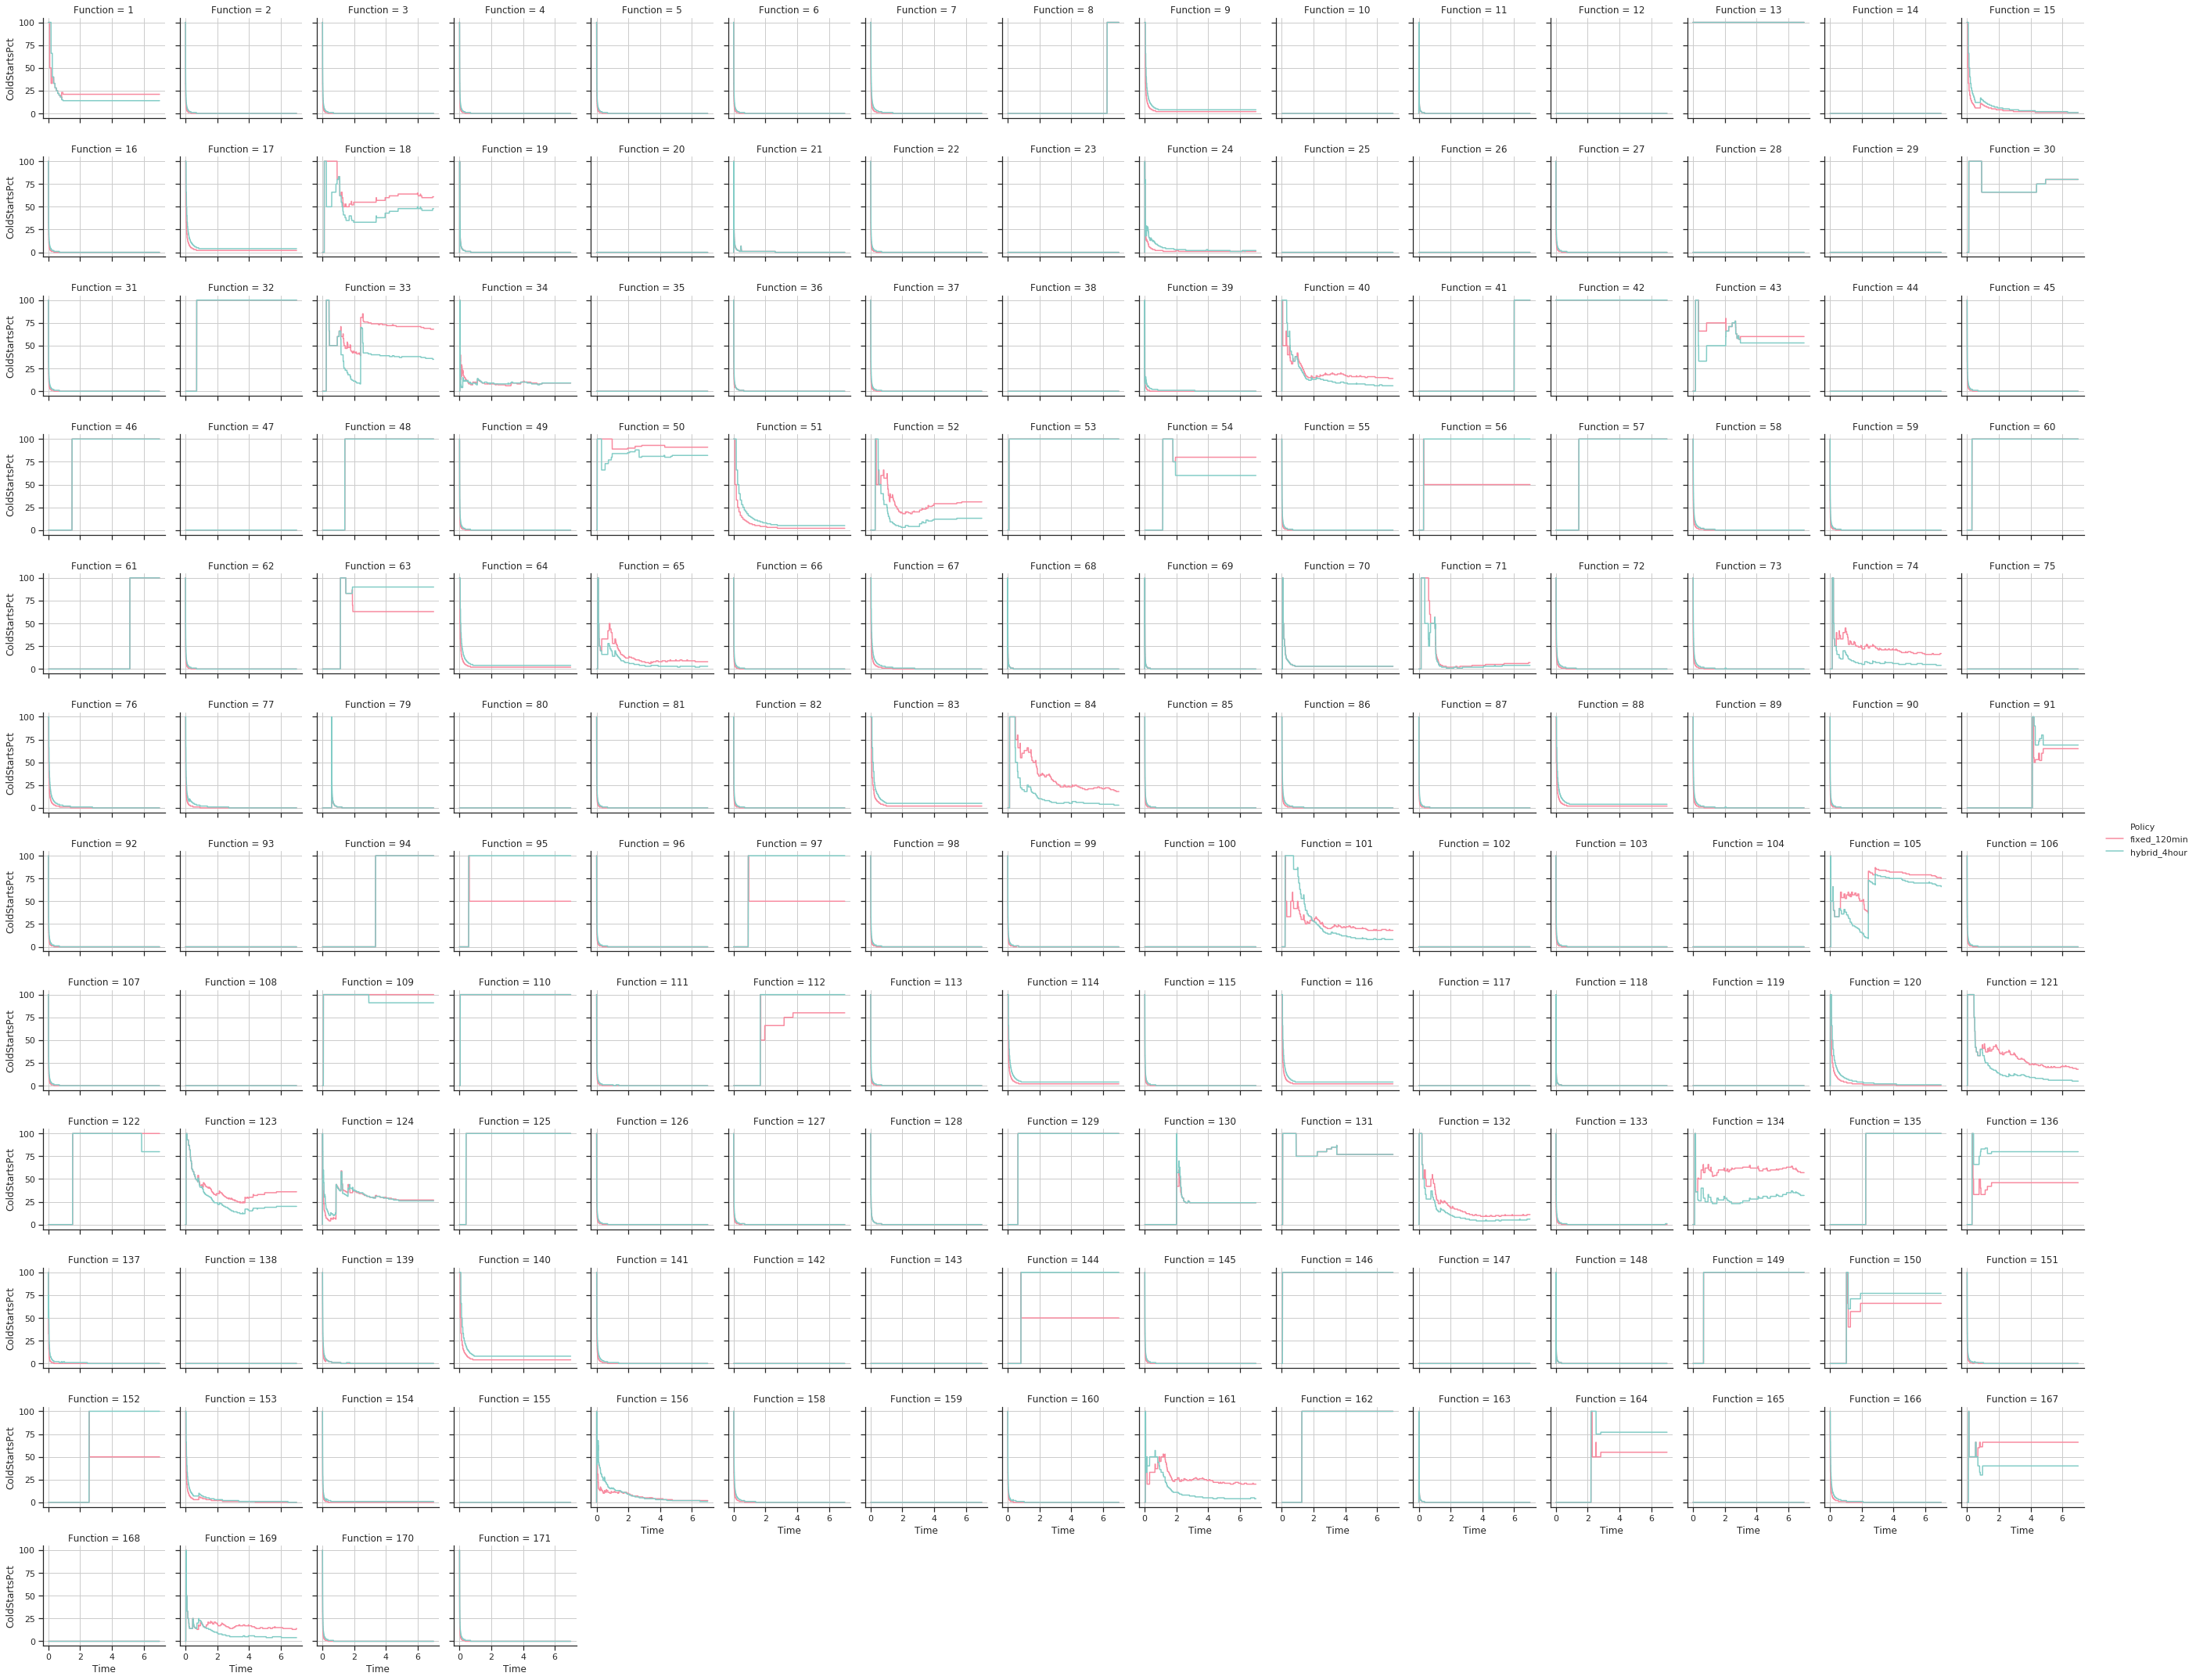

In [27]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    plot = sns.relplot(x="Time", y="ColdStartsPct", hue="Policy", kind="line", 
                       col="Function", col_wrap=15, height=2.5, palette=facet_palette, 
                       data=tidy_data)

#### Facet Grid Normalized Memory Time Evolution

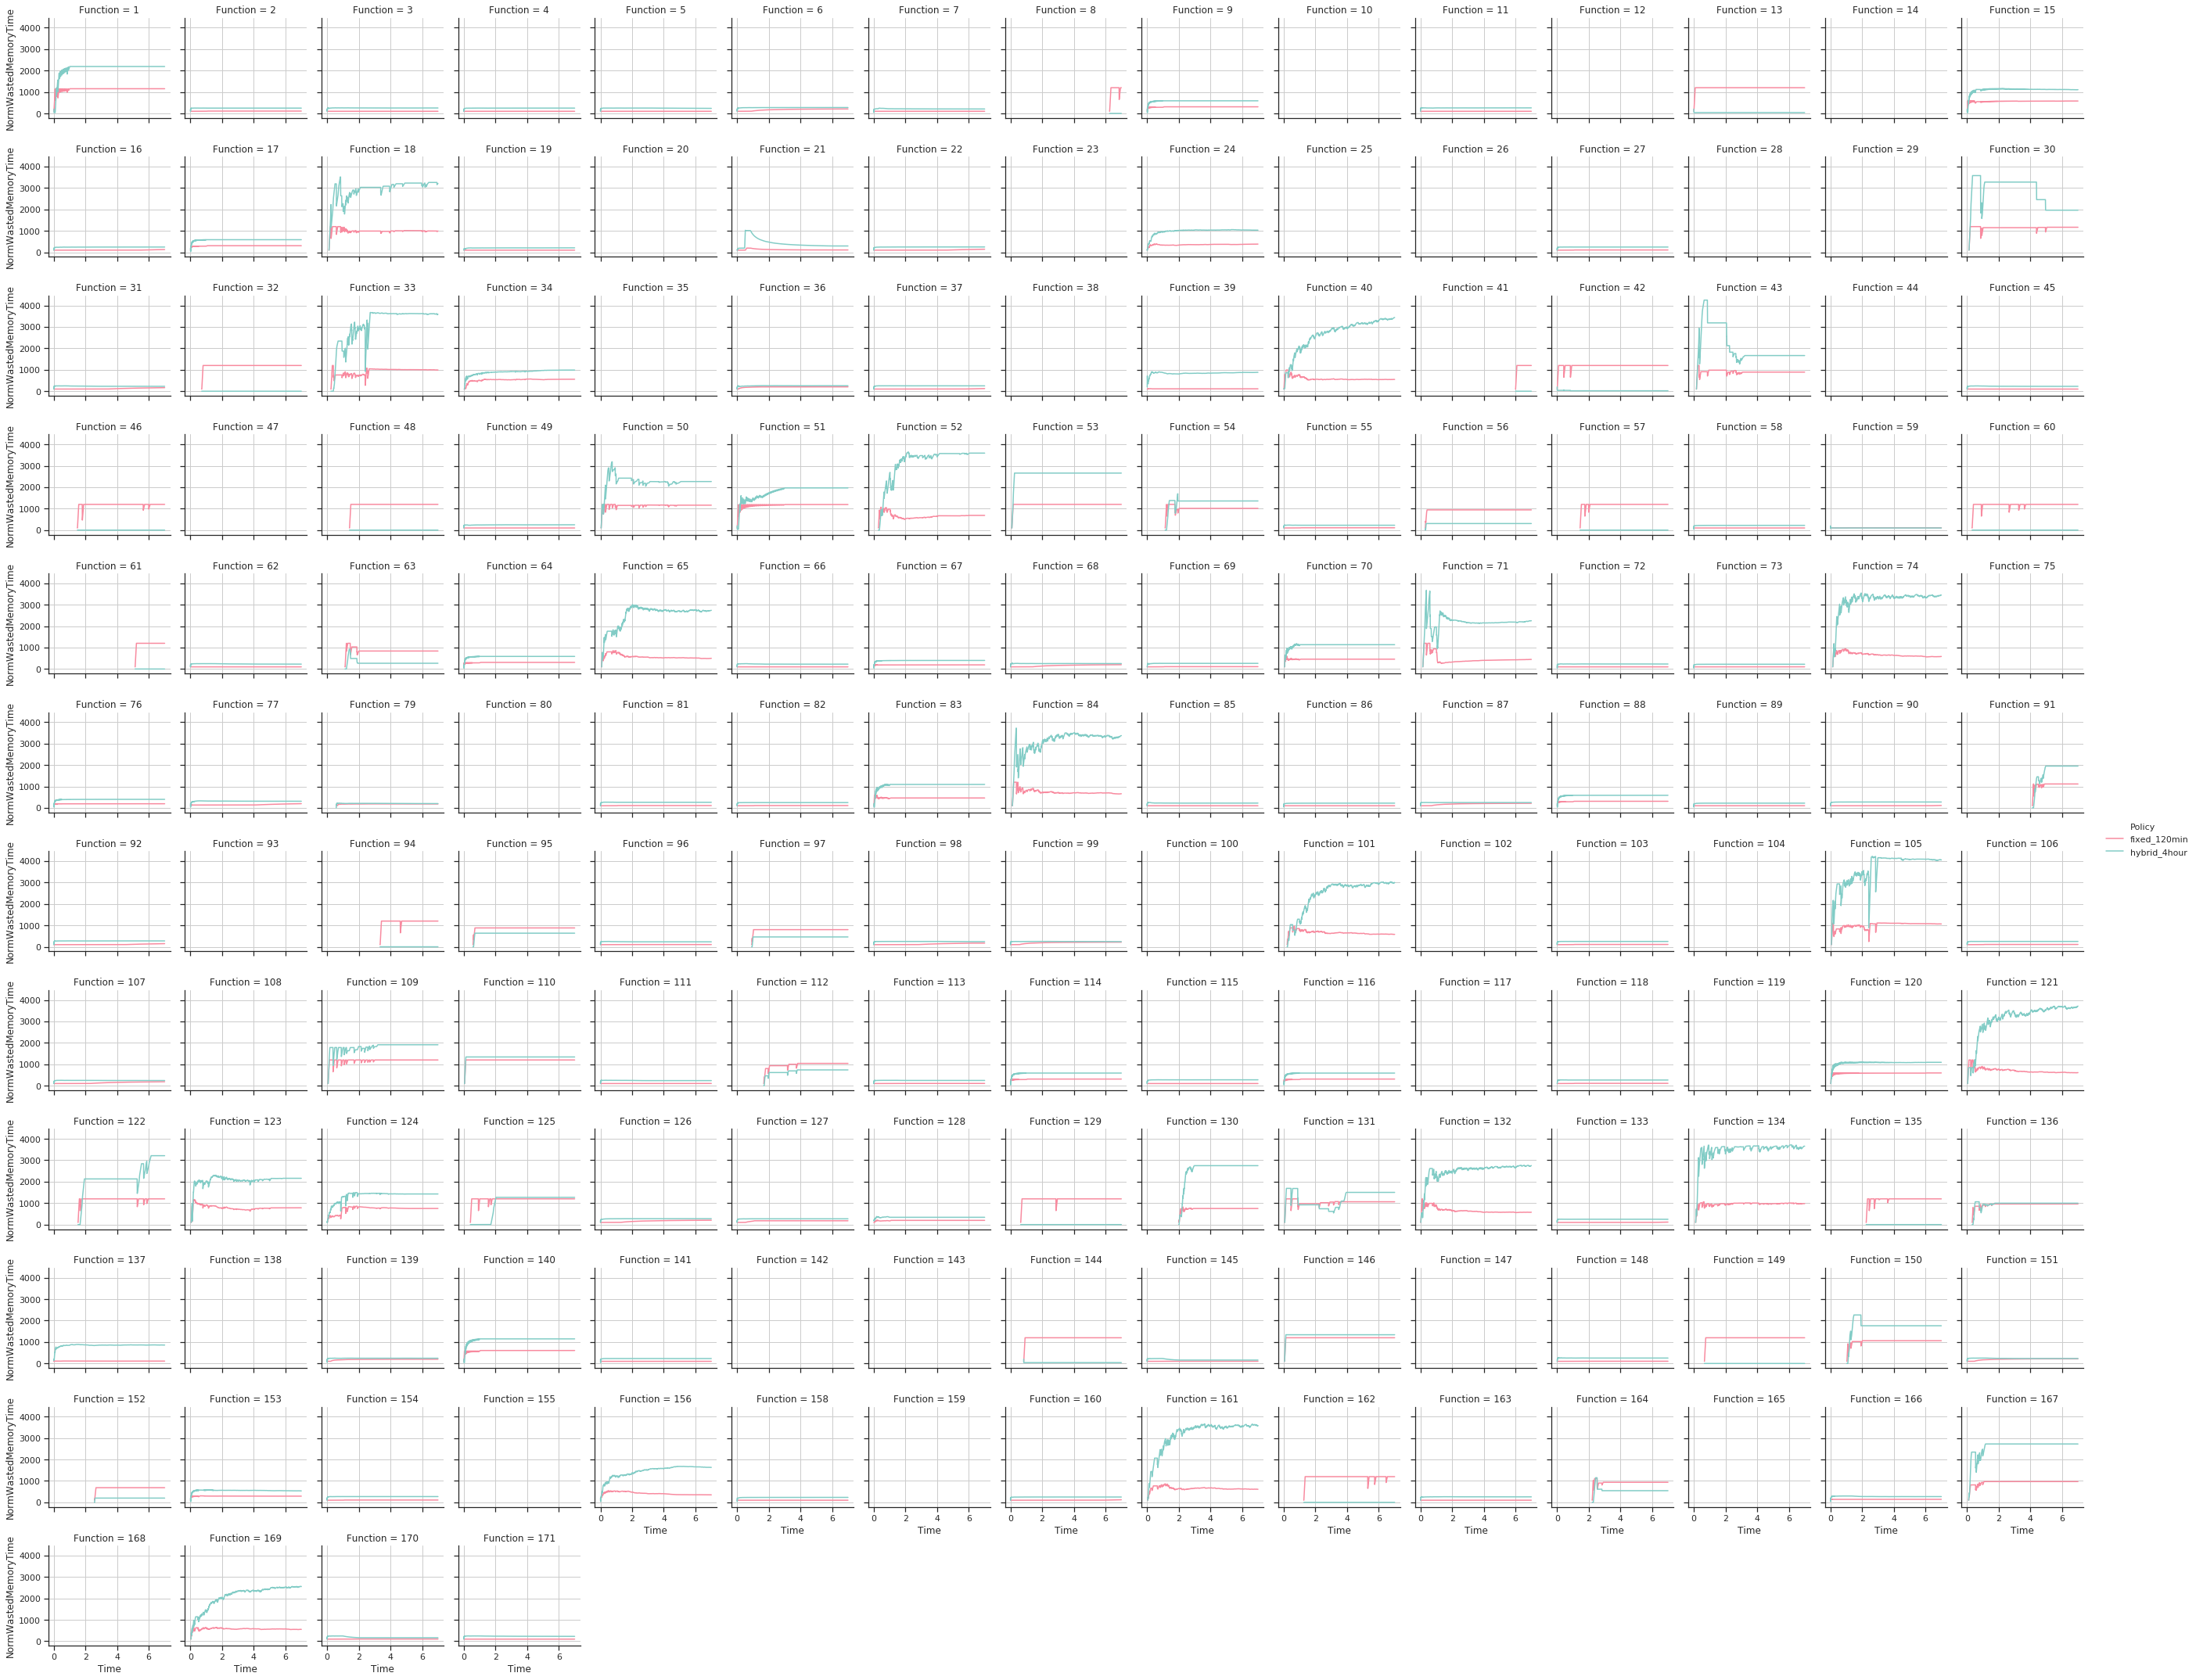

In [14]:
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    plot = sns.relplot(x="Time", y="NormWastedMemoryTime", hue="Policy", kind="line",
                       col="Function", col_wrap=15, height=2.5, palette=facet_palette,
                       data=tidy_data)
    plt.savefig("bonusfacetgrid.pdf", bbox_inches='tight')

## App specific Comparision Graphs 
Run the three iterations before proceeding with this part

### Processed trade off results (if available)

In [7]:
app_results = pd.read_csv("resources/azure/iteration1/tradeoff-results.csv")
app_results2 = pd.read_csv("resources/azure/iteration2/tradeoff-results.csv")
app_results3 = pd.read_csv("resources/azure/iteration3/tradeoff-results.csv")

### Computing total normalized memory time and 95th percentile app cold start

In [8]:
template = {'Experiment':[],
            'NormWastedMemoryTime':[],
            '95thAppColdStart':[],}
template_dtypes = {'Experiment':str,
                  'NormWastedMemoryTime':float,
                  '95thAppColdStart':float,}

processed_app_results = pd.DataFrame(data=template).astype(template_dtypes)

In [9]:
experiments=['Fixed_5min',
             'Fixed_10min (baseline)',
             'Fixed_20min',
             'Fixed_30min',
             'Fixed_45min',
             'Fixed_60min',
             'Fixed_90min',
             'Fixed_120min',
             'Hybrid_1hour',
             'Hybrid_2hour',
             'Hybrid_3hour',
             'Hybrid_4hour',]

normalized_times = []
percentiles = []

for experiment in experiments:
    if (experiment == "Fixed_10min (baseline)"):
        experiment = "Baseline"
    normalized_times.append(app_results[f'{experiment}WastedMemoryTime'].sum() * 100 / app_results['BaselineWastedMemoryTime'].sum())
    percentiles.append(np.percentile(app_results[f'{experiment}ColdStartPct'].values, 95))
    
processed_app_results['Experiment'] = experiments
processed_app_results['NormWastedMemoryTime'] = np.round(normalized_times)
processed_app_results['95thAppColdStart'] = np.round(percentiles)

### Trade-off between cold starts and wasted memory time for the fixed keep-alive policy and Azure's hybrid policy


In [10]:
def add_arrow(line, direction,position=None, size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
        arrow_style = '->'
    else:
        end_ind = start_ind - 1
        arrow_style = '<-'

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle=arrow_style, color=color),
        size=size
    )

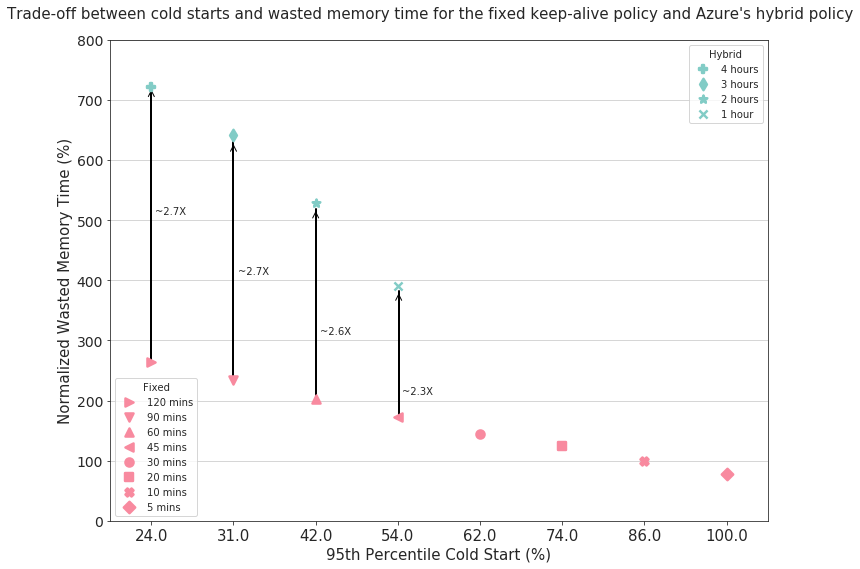

In [13]:
with sns.axes_style("ticks", {'axes.grid': True}):

    fig, ax =plt.subplots(1, figsize= (10,8))

    fig.suptitle("Trade-off between cold starts and wasted memory time for the fixed keep-alive policy and Azure's hybrid policy", fontsize=15)

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    ax.set_xlim(0,100)
    ax.set_ylim(0,800)

    palette={'Fixed_5min': "#f88a9f",
             'Fixed_10min (baseline)': "#f88a9f",
             'Fixed_20min': "#f88a9f",
             'Fixed_30min': "#f88a9f",
             'Fixed_45min': "#f88a9f",
             'Fixed_60min': "#f88a9f",
             'Fixed_90min': "#f88a9f",
             'Fixed_120min':"#f88a9f",
             'Hybrid_1hour': "#82ccc6",
             'Hybrid_2hour': "#82ccc6",
             'Hybrid_3hour': "#82ccc6",
             'Hybrid_4hour': "#82ccc6"}


    plot = sns.pointplot(y="NormWastedMemoryTime", x="95thAppColdStart", hue="Experiment",
                         data=processed_app_results.loc[8:12],
                         markers=['x','*','d','P'],
                         palette=palette,
                         scale=1.2,
                         ax=ax)

    plot = sns.pointplot(y="NormWastedMemoryTime", x="95thAppColdStart", hue="Experiment",
                         data=processed_app_results.loc[0:7],
                         markers=['D','X','s','o','<','^','v','>'],
                         palette=palette,
                         scale=1.2,
                         ax=ax)

    handles, labels = ax.get_legend_handles_labels()
    labels = ['1 hour','2 hours', '3 hours', '4 hours', 
              '5 mins','10 mins', '20 mins', '30 mins','45 mins', '60 mins', '90 mins', '120 mins']

    ax.legend(handles[:3:-1], labels[:3:-1], title='Fixed', loc='lower left', fontsize=10)

    leg = Legend(ax, handles[3::-1], labels[3::-1], title='Hybrid', loc='upper right')
    ax.add_artist(leg);

    ax.set_xlabel('95th Percentile Cold Start (%)', fontsize=15)
    ax.set_ylabel('Normalized Wasted Memory Time (%)', fontsize=15)

    line = plt.plot([0, 0.00], [721, 264], linewidth=2,color='k')[0]
    add_arrow(line, direction='left')
    plt.text(0.05, 510, '~2.7X')
    
    line = plt.plot([1., 1.], [630, 235], linewidth=2,color='k')[0]
    add_arrow(line, direction='left')
    plt.text(1.05, 410, '~2.7X')
    
    line = plt.plot([2., 2.], [519, 202], linewidth=2,color='k')[0]
    add_arrow(line, direction='left')
    plt.text(2.05, 310, '~2.6X')
    
    line = plt.plot([3.01, 3.01], [382, 172], linewidth=2,color='k')[0]
    add_arrow(line, direction='left')
    plt.text(3.05, 210, '~2.3X')
    
    plt.rcParams['xtick.labelsize']=15
    plt.rcParams['ytick.labelsize']=14


### Cold start behavior of some different resource management policies

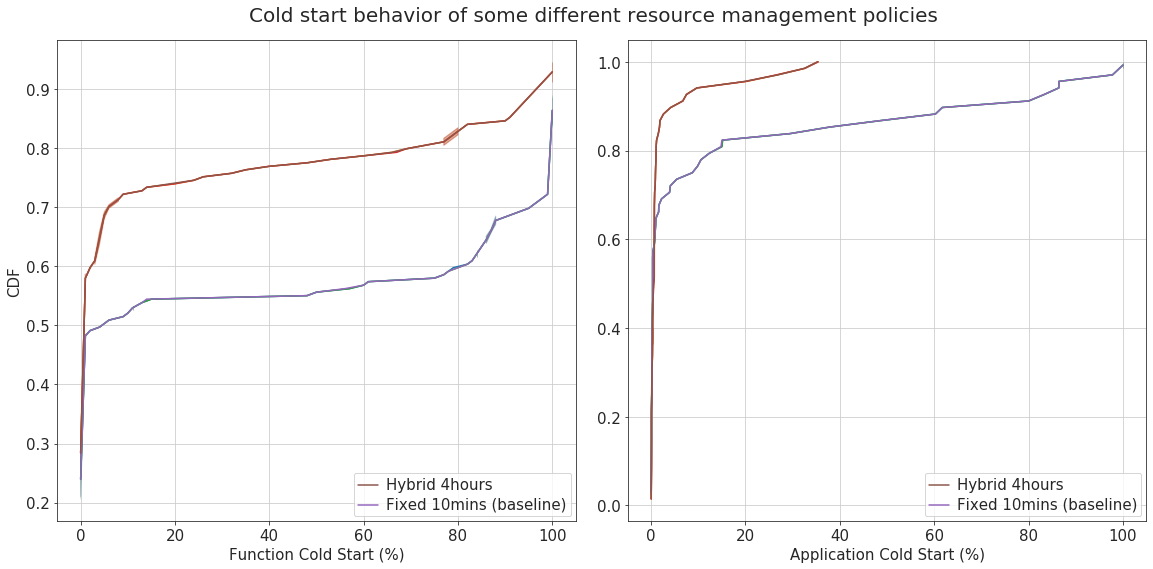

In [21]:
fixed_func = ECDF(results1.get("baseline")[results1.get("baseline")['Time'] == 7.0].ColdStartsPct.values)
hybrid_func = ECDF(results1.get("hybrid_4hour")[results1.get("hybrid_4hour")['Time'] == 7.0].ColdStartsPct.values)

fixed_func2 = ECDF(results2.get("baseline")[results2.get("baseline")['Time'] == 7.0].ColdStartsPct.values)
hybrid_func2 = ECDF(results2.get("hybrid_4hour")[results2.get("hybrid_4hour")['Time'] == 7.0].ColdStartsPct.values)

fixed_func3 = ECDF(results3.get("baseline")[results3.get("baseline")['Time'] == 7.0].ColdStartsPct.values)
hybrid_func3 = ECDF(results3.get("hybrid_4hour")[results3.get("hybrid_4hour")['Time'] == 7.0].ColdStartsPct.values)

fixed_app = ECDF(app_results[f'BaselineColdStartPct'].values)
hybrid_app = ECDF(app_results[f'Hybrid_4hourColdStartPct'].values)

fixed_app2 = ECDF(app_results2[f'BaselineColdStartPct'].values)
hybrid_app2 = ECDF(app_results2[f'Hybrid_4hourColdStartPct'].values)

fixed_app3 = ECDF(app_results3[f'BaselineColdStartPct'].values)
hybrid_app3 = ECDF(app_results3[f'Hybrid_4hourColdStartPct'].values)
    
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(1,2, figsize=(16,8))

    fig.suptitle('Cold start behavior of some different resource management policies', fontsize=20)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    ax[0].set_xlabel('Function Cold Start (%)', fontsize=15)
    ax[0].set_ylabel('CDF', fontsize=15)
    
    ax[1].set_xlabel('Application Cold Start (%)', fontsize=15)

    sns.lineplot(x=fixed_func.x, y=fixed_func.y, ax=ax[0])
    sns.lineplot(x=hybrid_func.x, y=hybrid_func.y, ax=ax[0])

    sns.lineplot(x=fixed_func2.x, y=fixed_func2.y, ax=ax[0])
    sns.lineplot(x=hybrid_func2.x, y=hybrid_func2.y, ax=ax[0])

    sns.lineplot(x=fixed_func3.x, y=fixed_func3.y, ax=ax[0], label="Fixed 10mins (baseline)")
    sns.lineplot(x=hybrid_func3.x, y=hybrid_func3.y, ax=ax[0], label="Hybrid 4hours")

    sns.lineplot(x=fixed_app.x, y=fixed_app.y, ax=ax[1])
    sns.lineplot(x=hybrid_app.x, y=hybrid_app.y, ax=ax[1])

    sns.lineplot(x=fixed_app2.x, y=fixed_app2.y, ax=ax[1])
    sns.lineplot(x=hybrid_app2.x, y=hybrid_app2.y, ax=ax[1])

    sns.lineplot(x=fixed_app3.x, y=fixed_app3.y, ax=ax[1], label="Fixed 10mins (baseline)")
    sns.lineplot(x=hybrid_app3.x, y=hybrid_app3.y, ax=ax[1], label="Hybrid 4hours")


    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1], loc="lower right")
    plt.setp(ax[0].get_legend().get_texts(), fontsize=15)  # for legend text
    
    handles1, labels1 = ax[1].get_legend_handles_labels()
    ax[1].legend(handles1[::-1], labels1[::-1], loc="lower right")
    plt.setp(ax[1].get_legend().get_texts(), fontsize=15)  # for legend text
    
    
    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)

### Cold start behavior of fixed keep alive resource management policies (+ no unloading)

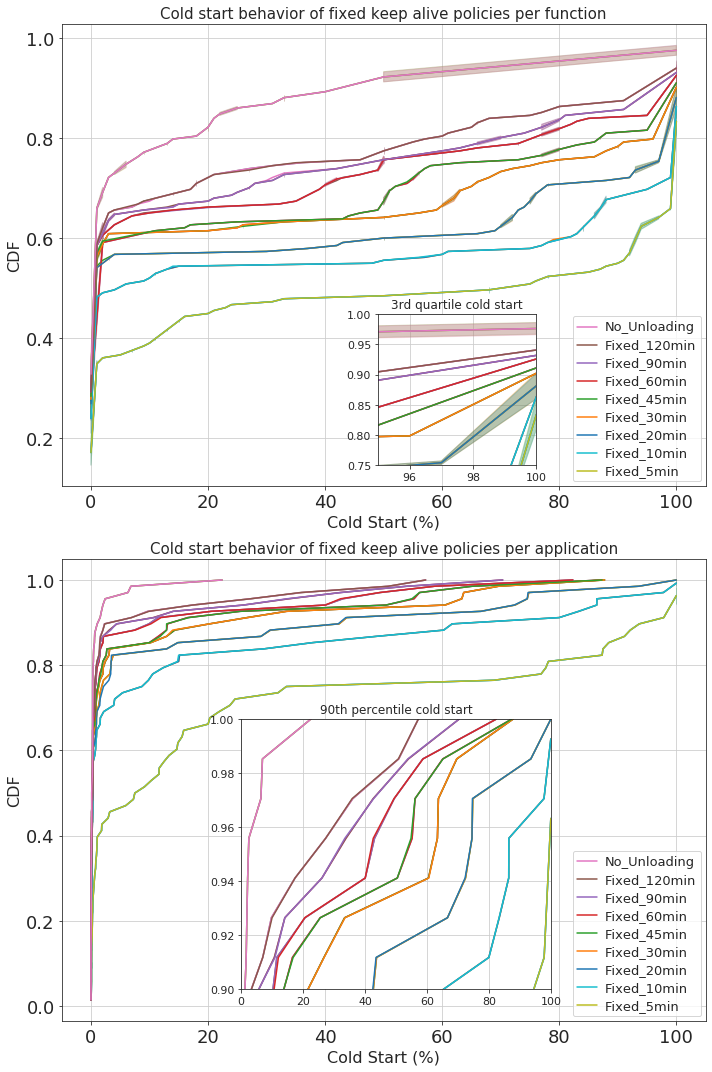

In [84]:
func_cdfs = []
app_cdfs = []

func_cdfs2 = []
app_cdfs2 = []

func_cdfs3 = []
app_cdfs3 = []

experiments=['Fixed_5min',
             'Fixed_10min',
             'Fixed_20min',
             'Fixed_30min',
             'Fixed_45min',
             'Fixed_60min',
             'Fixed_90min',
             'Fixed_120min',
             'No_Unloading']

for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs.append(ECDF(results1.get(experiment.lower())[results1.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs.append(ECDF(app_results[f'{experiment}ColdStartPct'].values))
    
for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs2.append(ECDF(results2.get(experiment.lower())[results2.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs2.append(ECDF(app_results[f'{experiment}ColdStartPct'].values))

for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs3.append(ECDF(results3.get(experiment.lower())[results3.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs3.append(ECDF(app_results3[f'{experiment}ColdStartPct'].values))
    
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(2, 1, figsize=(10,15))
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    ax[0].set_title(f"Cold start behavior of fixed keep alive policies per function", fontsize=15)
    ax[1].set_title(f"Cold start behavior of fixed keep alive policies per application", fontsize=15)

    ax[0].set_ylabel('CDF', fontsize=16)
    ax[0].set_xlabel('Cold Start (%)', fontsize=16)

    ax[1].set_xlabel('Cold Start (%)', fontsize=16)
    ax[1].set_ylabel('CDF', fontsize=16)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs[index].x, y=func_cdfs[index].y, ax=ax[0])
        sns.lineplot(x=app_cdfs[index].x, y=app_cdfs[index].y, ax=ax[1])

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs2[index].x, y=func_cdfs2[index].y, ax=ax[0])
        sns.lineplot(x=app_cdfs2[index].x, y=app_cdfs2[index].y, ax=ax[1])

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs3[index].x, y=func_cdfs3[index].y, ax=ax[0], label=f"{experiment}")
        sns.lineplot(x=app_cdfs3[index].x, y=app_cdfs3[index].y, ax=ax[1], label=f"{experiment}")
        
        
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].tick_params(axis='both', which='minor', labelsize=18)
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    ax[1].tick_params(axis='both', which='minor', labelsize=18)

    ax2 = plt.axes([0.34, 0.08, .43, .25], facecolor='w')
    ax3 = plt.axes([0.53, 0.565, .22, .14], facecolor='w')
    
    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs[index].x, y=func_cdfs[index].y, ax=ax3)
        sns.lineplot(x=app_cdfs[index].x, y=app_cdfs[index].y, ax=ax2)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs2[index].x, y=func_cdfs2[index].y, ax=ax3)
        sns.lineplot(x=app_cdfs2[index].x, y=app_cdfs2[index].y, ax=ax2)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=func_cdfs3[index].x, y=func_cdfs3[index].y, ax=ax3, label=f"{experiment}")
        sns.lineplot(x=app_cdfs3[index].x, y=app_cdfs3[index].y, ax=ax2, label=f"{experiment}")
    
    ax2.legend().set_visible(False)

    ax2.set_title('90th percentile cold start')
    ax2.set_xlim([0,100])
    ax2.set_ylim([0.90,1.0])
    
    ax2.tick_params(axis='both', which='major', labelsize=11)
    ax2.tick_params(axis='both', which='minor', labelsize=11)
    
    ax3.legend().set_visible(False)

    ax3.set_title('3rd quartile cold start')
    ax3.set_xlim([95,100])
    ax3.set_ylim([0.75,1.0])
    
    ax3.tick_params(axis='both', which='major', labelsize=11)
    ax3.tick_params(axis='both', which='minor', labelsize=11)


    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[::-1], labels[::-1])
    plt.setp(ax[0].get_legend().get_texts(), fontsize=13)


    handles1, labels1 = ax[1].get_legend_handles_labels()
    ax[1].legend(handles1[::-1], labels1[::-1])
    plt.setp(ax[1].get_legend().get_texts(), fontsize=13)  
    
    fig.tight_layout()


### Cold start behavior of all different resource management policies

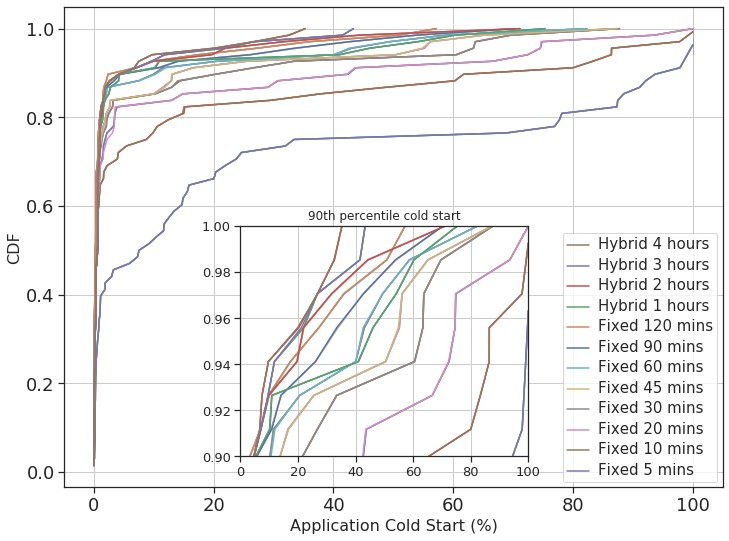

In [8]:
func_cdfs = []
app_cdfs = []

func_cdfs2 = []
app_cdfs2 = []

func_cdfs3 = []
app_cdfs3 = []

experiments=['Fixed_5min',
             'Fixed_10min',
             'Fixed_20min',
             'Fixed_30min',
             'Fixed_45min',
             'Fixed_60min',
             'Fixed_90min',
             'Fixed_120min',
             'Hybrid_1hour',
             'Hybrid_2hour',
             'Hybrid_3hour',
             'Hybrid_4hour']

for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs.append(ECDF(results1.get(experiment.lower())[results1.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs.append(ECDF(app_results[f'{experiment}ColdStartPct'].values))
    
for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs2.append(ECDF(results2.get(experiment.lower())[results2.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs2.append(ECDF(app_results[f'{experiment}ColdStartPct'].values))

for experiment in experiments:
    if (experiment == "Fixed_10min"):
        experiment = "Baseline"
    func_cdfs3.append(ECDF(results3.get(experiment.lower())[results3.get(experiment.lower())['Time'] == 7.0].ColdStartsPct.values))
    app_cdfs3.append(ECDF(app_results3[f'{experiment}ColdStartPct'].values))
    
with sns.color_palette("Paired") and sns.axes_style("ticks", {'axes.grid': True}):
    fig, ax =plt.subplots(1, figsize=(10,8))

#     fig.suptitle('Cold start behavior of all resource management policies', fontsize=15)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    ax.set_xlabel('Application Cold Start (%)', fontsize=16)
    ax.set_ylabel('CDF', fontsize=16)
    
    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs[index].x, y=app_cdfs[index].y, ax=ax)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs2[index].x, y=app_cdfs2[index].y, ax=ax)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs3[index].x, y=app_cdfs3[index].y, ax=ax, label=f"{experiment}")
    
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18)

    ax2 = plt.axes([0.30, 0.14, .40, .40], facecolor='w')
    
    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs[index].x, y=app_cdfs[index].y, ax=ax2)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs2[index].x, y=app_cdfs2[index].y, ax=ax2)

    for index,experiment in enumerate(experiments,start = 0):
        sns.lineplot(x=app_cdfs3[index].x, y=app_cdfs3[index].y, ax=ax2, label=f"{experiment}")
    
    ax2.legend().set_visible(False)

    ax2.set_title('90th percentile cold start')
    ax2.set_xlim([0,100])
    ax2.set_ylim([0.90,1.0])
    
    ax2.tick_params(axis='both', which='major', labelsize=13)
    ax2.tick_params(axis='both', which='minor', labelsize=13)

    handles, labels = ax.get_legend_handles_labels()
    labels = ['Fixed 5 mins',
             'Fixed 10 mins',
             'Fixed 20 mins',
             'Fixed 30 mins',
             'Fixed 45 mins',
             'Fixed 60 mins',
             'Fixed 90 mins',
             'Fixed 120 mins',
             'Hybrid 1 hours',
             'Hybrid 2 hours',
             'Hybrid 3 hours',
             'Hybrid 4 hours']
    ax.legend(handles[::-1], labels[::-1], loc='lower right')
    plt.setp(ax.get_legend().get_texts(), fontsize=15)
    
    plt.savefig("Allpoliciescomparisionapp (polished).pdf", bbox_inches='tight')
